In [1]:
import numpy as np

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept import oyster

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Create a retina
r_sampling = 250       # spatial sampling of retina
axon_lambda = 3        # constant that determines fall-off with axonal distance
rot = 0 * np.pi / 180  # retina rotation angle
retina = e2cm.Retina(sampling=r_sampling, axon_lambda=axon_lambda, rot=rot,
                     xlo=-2500, xhi=2500, ylo=-2500, yhi=2500)

In [3]:
# Place an Argus I array on the retina
argus = e2cm.ArgusI(x_center=-900, y_center=110, h=0, rot=np.pi/4)

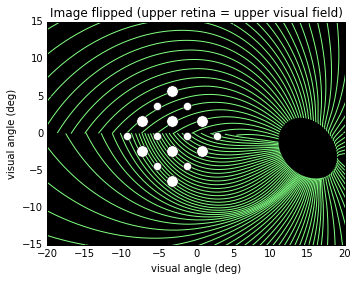

In [4]:
# Plot axon bundles (plot every 5th for the sake of visualization)
fig, ax = plt.subplots(1)
ax.set_axis_bgcolor('black')
ax.plot(retina.jan_x[:, ::5], -retina.jan_y[:, ::5], c=(0.5, 1, 0.5))

# Plot location of implant on top of axon bundles
for e in argus.electrodes:
    ax.plot(e2cm.micron2deg(e.x), -e2cm.micron2deg(e.y), 'ow', markersize=np.sqrt(e.r/2))
ax.set_aspect('equal')
ax.set_xlim(-20, 20)
ax.set_xlabel('visual angle (deg)')
ax.set_ylim(-15, 15)
ax.set_ylabel('visual angle (deg)')
ax.set_title('Image flipped (upper retina = upper visual field)')
fig.savefig('jansonius_argusI.eps')

In [5]:
# We derive the effective current stimulation (ecs; passed through the effect of the retinal layout, axons, etc.) 
# in addition to the current (cs):
ecs, cs  = retina.electrode_ecs(argus)

In [6]:
# Stimulation params
tsample = 0.005 / 1000  # Sample step (s)
dur = 0.5               # Stimulation duration (s)
el_idx = 4              # Electrode to stimulate
rs = 30                 # Resampling framrate of brightness movie (fps)

# The temporal model contains the cascade of operations that leads from pulse to percept:
tm = ec2b.TemporalModel(tsample=tsample)

In [7]:
# Generate a list of pulse trains, one for each electrode
# Initialize all with zeros
pt = [e2cm.Psycho2Pulsetrain(tsample, freq=0, amp=0, dur=dur)] * len(argus.electrodes)

# Stimulate a single electrode
pt[el_idx] = e2cm.Psycho2Pulsetrain(tsample, freq=50, amp=20, dur=dur)

In [8]:
mov = ec2b.pulse2percept(tm, ecs, retina, pt, int(rs), dolayer='NFL', engine='serial', dojit=False, tol=0.01)

TypeError: Image data can not convert to float

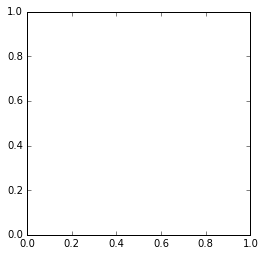

In [9]:
frame = ec2b.get_brightest_frame(mov)
plt.imshow(frame, cmap='gray')